<a href="https://colab.research.google.com/github/inmas-training/fa21-statistical-methods-workshop/blob/main/04b-logistic-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview 

Within this notebook, we introduce logistic regression and associated model inference techniques. Please note, this notebook emphasizes logistic regression using `statsmodels`.

## Diagnostics


In [1]:
#@title (Hidden) Diagnostic Check
import os
import sys
import pandas as pd
import numpy as np
%tensorflow_version 2.x
import statsmodels 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt

print(f"\nPython environment:\n{sys.version}")
print("\nStatistical packages loaded: ")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"statsmodels: {statsmodels.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

print(f"\nRuntime location:")
try:
  from google.colab import drive
  is_google_colab = True
  print("Notebook is on Google CoLab")
except:
  is_google_colab = False
  print("Notebook is being run locally or through another source.")


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Python environment:
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]

Statistical packages loaded: 
pandas: 1.1.5
numpy: 1.19.5
statsmodels: 0.10.2
matplotlib: 3.2.2

Runtime location:
Notebook is on Google CoLab


## Save a copy of this notebook!!

Before we get started, it is crucially important that you **save a copy of the notebook** to your Google Drive! Please go to: 

```
File -> Save a Copy in Drive
```



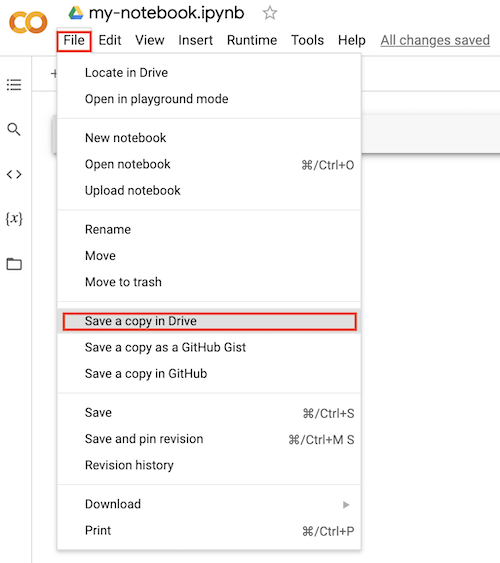

**If you _forget_ to save a copy of the notebook, all of your work will be lost when you close out of Google Colab.**

# Logistic Regression



After the last notebook, the true beauty of linear regression was on display for all to see. Linear regression is highly flexibility, but only works well if we have a continuous response variable. 

In the cases were we have a binary or discrete response variable, we must look elsewhere. Binary response variables are problematic because they only allow for two values to be set in the $Y$ variable. For instance, we could work with only data labelled "Yes" and "No", or "True" and "False".  In both of these instances, we could generate a dummy or indicator variable mapping "Yes"/"True" to 1 and  "No"/"False" to 0. Previously, we only examined the inclusion of categorical variables within the predictors through the design matrix. In this case, we're seeking to establish a new set of methods that are closely related to linear regression but fundamental different. 

We need to establish this new paradigm to answer questions regarding whether or not an event occurred: 

- Did a student respond correctly to an exam item?
- Does the patient have HIV? 
- Is Schrodinger’s cat dead or alive?


|Logistic regression |	Linear regression
|:-----|:----|
Target variable is categorical (binary or dichotomous) | Continuous variable |
| Estimates probabilities of the events (predicted values $0 \le \pi \le 1$)	| Estimates quantitative response across $(-\infty, +\infty)$
| Coefficients estimated with maximum likelihood estimation (MLE)	| Least square method |
| S-shaped (sigmoidal) curve relationship between target and input | Linear relationship 
| Predicts categorical response (class assignment)	| Predicts quantitative response 
| Coefficients interpreted in terms of odds or odds ratio (OR)	| Coefficients  interpreted directly based on the estimated values |
| Does not require the assumptions of normality and equal variances of errors, but requires errors to be independent	| Requires assumptions of normality and equal variances of errors

## Simulate logistic regression data

When we are interested in studying a new phenomenon, 
we first try to setup a means to generate data to study it!

Within the next block of code, we simulate data by adhering to: 

$$
Y_i \sim \mathrm{Bernoulli}(p_i), \quad p_i = \frac{e^{\beta_0 + \beta_1 X}}{1 + e^{\beta_0 + \beta_1 X}} 
$$

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, bernoulli

# Set beta parameters
b0, b1 = -0.7, 2.1 

# Select size of observations in data set
n_observations = 100

# Simulate random variables underneath a normal distribution
x = norm.rvs(size = n_observations)

# Compute odds
odds = np.exp(b0 + b1*x)

# Determine the class of Y (either 0 or 1) 
y = bernoulli.rvs(p = odds/(1 + odds), size = n_observations)

# Create the data set
df = pd.DataFrame({'x':x, 'y':y})

display(df.head(10))

,x,y
0,-0.597349,0
1,-1.120993,0
2,-1.669107,0
3,-1.647576,0
4,0.450072,0
5,0.234872,0
6,-0.265129,0
7,-0.167882,0
8,2.116282,1
9,-2.182702,0


We can observe the number of target values generated by using: 

In [3]:
df.y.value_counts()

0    65
1    35
Name: y, dtype: int64

We can visualize the distribution by using a boxplot. 

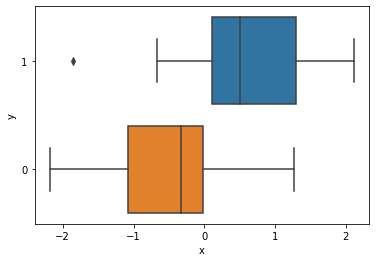

In [4]:
import seaborn as sns 
sns.boxplot(x='x', y='y', data=df, orient='h', order=[1,0]);

If we plot the data using a scatter plot, we notice an interesting pattern of the data being confined solely to two horizontal lines $y = 1$ and $y = 0$ as the value of $x$ changes.

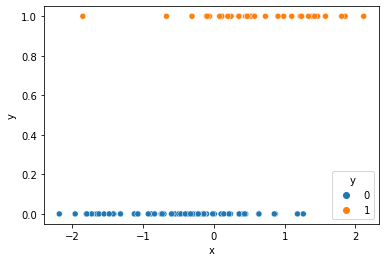

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt

sns.scatterplot(x="x", y = "y", hue = "y", data = df);

Let's consider trying to estimate a response variable $\pi_i \in [0, 1]$. If we were able to use linear regression, then we would fit a model like so:
$$
\pi = \beta_0 + \beta_1 X
$$


In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Specify the desired model of y regressing onto x
model_formula = smf.ols('y ~ x', data = df)

# Fit the model to the data
simulated_model = model_formula.fit()

# Obtain the model summary
summary_simulated_model = simulated_model.summary()

# Display output
print(summary_simulated_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     42.84
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           2.73e-09
Time:                        16:26:26   Log-Likelihood:                -49.730
No. Observations:                 100   AIC:                             103.5
Df Residuals:                      98   BIC:                             108.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3755      0.040      9.300      0.0

Looking at the output, the model at first glance appears to be performing well; however, we're going to run into issues as we _restricted_ the value of $Y$ from $(-\inf, +\inf)$ to $[0, 1]$. 

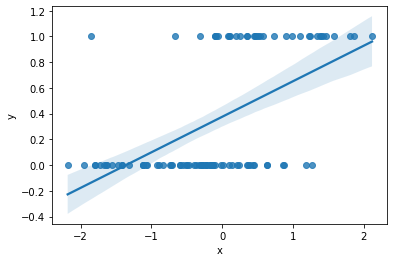

In [7]:
import seaborn as sns
sns.regplot(x='x', y='y', data=df, logistic=False);

From the graph, we note that our linear line surpasses the bound of $[0, 1]$! As a result, we could predict a probability greater than 1 or less than 0!!! 

## Your Turn: Predicting Poorly

Using the OLS estimates given above, please compute two predictions that would fall outside the range for a valid probability, e.g. $(-\infty, 0)$ and $(1, +\infty)$

In [8]:
## Code here

## Sigmoid Function


Well, what should we do? The answer here is to dig into statistics and use 

$$
\log \left( \frac{\pi}{1-\pi} \right) = logit(\pi) = \beta_0 + \beta_1 X
$$

This transformation is called the **logit function**. Note that this implies that

$$\pi = \frac{e^{\beta_0 + \beta_1 X}}{1 + e^{\beta_0 + \beta_1 X}} \in (0,1)$$



Thus, we are "linking" between the $\mathbb{R}$ space and the probability space $0 \le p \le 1$. The link appears as an S-curve inside $(0,1)$ and excludes $0,1$ due to the domain of $\log()$.


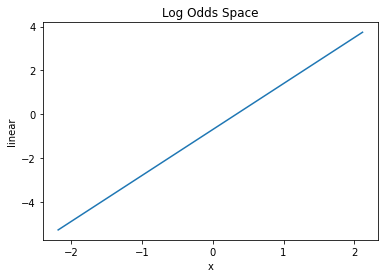

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns;

# Make a grid of x values for plotting the curve
xgrid = np.linspace(df['x'].min(), df['x'].max(), 100)

# Compute odds over the grid
ogrid = np.exp(b0 + b1*xgrid)

df_default = pd.DataFrame(
    {"x": xgrid, 
     "linear": np.log(ogrid),
     "prob": ogrid/(1+ogrid)}
    )

# Graph the probability curve
sns.lineplot(x = "x", y = "linear", data = df_default)
plt.title("Log Odds Space");

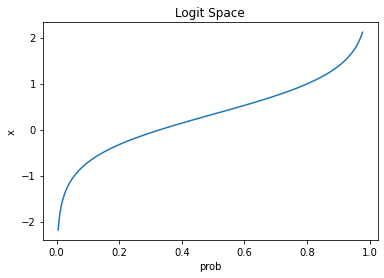

In [10]:
sns.lineplot(x = "prob", y = "x", data = df_default);
plt.title("Logit Space");

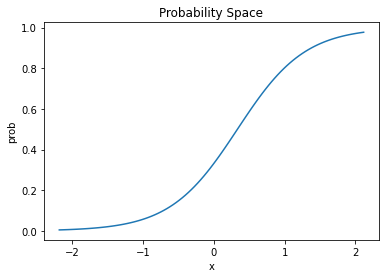

In [11]:
# Graph the probability curve
sns.lineplot(x = "x", y = "prob", data = df_default);
plt.title("Probability Space");

As it relates the simulation data, we can see 

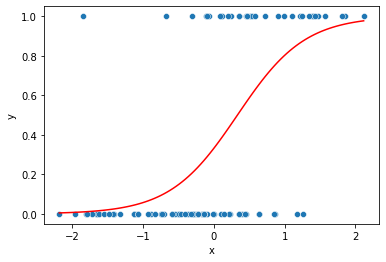

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns;

# Plot raw data
sns.scatterplot(x='x', y='y', data = df)

# Make a grid of x values for plotting the curve
xgrid = np.linspace(df['x'].min(), df['x'].max(), 100)

# Compute odds over the grid
ogrid = np.exp(b0 + b1*xgrid)

# Graph the probability curve
plt.plot(xgrid, ogrid/(1+ogrid), color='r')
plt.show()

### Aside: Alternative Form of Logistic Regression: Probabilities

Within this section, we describe how we can re-arrange the terms to obtain probabilities in logistic regression.. 

Rearranging the logistic regression model for $P\left( {{Y} = 1} \right) = {\pi }$.

$$
\begin{align*}
    \log \left( {\frac{{{\pi}}}{{1 - {\pi}}}} \right) &= {X^{\top}}\beta   \\
    \frac{{{\pi}}}{{1 - {\pi}}} &= \exp \left( {{X^{\top}}\beta } \right)  \\
    {\pi} &= \left( {1 - {\pi}} \right)\exp \left( {{X^{\top}}\beta } \right)  \\
    {\pi} &= \exp \left( {{X^{\top}}\beta } \right) - {\pi}\exp \left( {{X^{\top}}\beta } \right)  \\
    {\pi} + {\pi}\exp \left( {{X^{\top}}\beta } \right) &= \exp \left( {{X^{\top}}\beta } \right)  \\
    {\pi}\left[ {1 + \exp \left( {{X^{\top}}\beta } \right)} \right] &= \exp \left( {{X^{\top}}\beta } \right)  \\
    {\pi} &= \frac{{\exp \left( {{X^{\top}}\beta } \right)}}{{1 + \exp \left( {{X^{\top}}\beta } \right)}} \\
    P\left( {{Y} = 1} \right) = {\pi} &= \frac{{\exp \left( {{\beta _0} + {\beta _1}{x_{1}} +  \cdots  + {\beta _n}{x_{n}}} \right)}}{{1 + \exp \left( {{\beta _0} + {\beta _1}{x_{1}} +  \cdots  + {\beta _n}{x_{n}}} \right)}} 
\end{align*}
$$

## Generalized Linear Models (GLM)

From the previous example, we saw that we were in trouble when we tried to apply our linear regression framework onto a binary response.

Luckily, one of the most important developments in statistics allows us to proceed. This development was the generalization of the linear model.

The generalization allows regression models to encompass a much more diverse class of probabilistic distributions under the **Generalized Linear Model**

When we talk about a linear model, we are specifically making a comment on the **linearity relationship in the parameters**. So, the relationship between a function of $E[{Y_i}]$ and the parameters is linear e.g. 
  \begin{align*}
    {y_i} &= {\beta _0} + {\beta _1}{x_i} + {\varepsilon _i}  \\
    {y_i} &= {\beta _0} + {\beta _1}{x_i} + {\beta _2}x_i^2 + {\varepsilon _i}  \\
    {y_i} &= {\beta _0} + \exp \left( {{\beta _1}} \right){x_i} + {\varepsilon _i} 
  \end{align*}
  
  **NOT:**
  \begin{align*}
    {y_i} &= {\beta _0} + x_i^{{\beta _1}} + {\varepsilon _i} \\
    {y_i} &= {\beta _0}\exp \left( {{\beta _1}{x_i}} \right) + {\varepsilon _i} 
  \end{align*}


GLM models are built on the notion that there are: 

- **Random Component** is the distribution of $Y_i$, which is assumed to be apart of the exponential family:

$${f_{{Y_i}}}\left( {{y_i};{\theta _i}} \right) = a\left( {{\theta _i}} \right)b\left( {{y_i}} \right)\exp \left[ {{y_i}Q\left( {{\theta _i}} \right)} \right],$$

we call $Q\left( {{\theta _i}} \right)$ the natural parameter.

- **Systematic Component** is the linear predictor ($\eta _i$) produced by the covariates and regression coefficients.

$${\eta _i} = {\beta _0} + {\beta _1}{x_{1i}} +  \cdots  + {\beta _p}{x_{pi}} = \sum\limits_{j = 1}^p {{\beta _j}{x_{ij}}} $$

- **Link Function**, $g$, that connects the random and systematic component.

$$g\left( {{\mu _i}} \right) = {\eta _i} = Q\left( {{\theta _i}} \right)$$

where $g$ is monotonic and differentiable.

We can further extend the random component for a dispersion parameter (stretching or squeezing the distribution).

### Aside: Multiple Linear Regression as a GLM

Consider the Multiple Linear Regression model:

\begin{align*}
{Y_i} & = {\beta _0} + {\beta _1}{x_{1i}} +  \cdots  + {\beta _p}{x_{pi}} + \varepsilon \\
& \textrm{where } \varepsilon \sim N\left({0,\sigma ^2}\right)
\end{align*}
        
We can confirm that the MLR model can be transformed into GLM since:

- **Random Component**: $Y_i\sim N\left({\mu _i, \sigma ^2}\right)$, which is apart of the exponential family.
- **Systematic Component**: ${\eta _i} = \sum\limits_{j = 1}^p {{\beta _j}{x_{ji}}}$
- **Link Function**: $\mu _i = g\left({\mu_i}\right)=\eta _i= \sum\limits_{j = 1}^p {{\beta _j}{x_{ji}}}$. 

_Note:_ The link function is the identity, e.g. $\operatorname{Identity}(x) = x$.


## Derivation of Logistic Regression as a GLM

Revisiting the idea that $Y_i = 0$ or $1$, we have really described a Bernoulli variable with probability $\pi _{i}$.

So, we have $Y_i \sim Bernoulli\left({\pi}\right)$

To show that it belongs to GLM, we need to show it belongs to the exponential family. From there, we will have the link function. 

$$
\begin{align*}
    f\left( {{y_i};\pi _{i} } \right) &= {\pi _{i} ^{{y_i}}}{\left( {1 - \pi _{i} } \right)^{1 - {y_i}}} 
    \\
   &= \left( {1 - \pi _{i} } \right) \cdot \frac{{{\pi _{i} ^{{y_i}}}}}{{{{\left( {1 - \pi _{i} } \right)}^{{y_i}}}}} \hfill 
   \\
   &= \left( {1 - \pi _{i} } \right)\left( 1 \right)\exp \left\{ {{y_i}\log \left( {\frac{\pi _{i} }{{1 - \pi _{i} }}} \right)} \right\} 
  \end{align*}
  $$

where $a\left( {{\pi _i}} \right) = \left( {1 - {\pi _i}} \right), b\left( {{y_i}} \right) = 1, {\text{ and }}Q\left( {{\pi _i}} \right) = \log \left( {\frac{{{\pi _i}}}{{1 - {\pi _i}}}} \right)$

Recall that : $P\left( {{Y_i} = 1} \right) = \pi _{i}$ and $P\left( {{Y_i} = 0} \right) = 1 - \pi _{i}$.


Because of the "link", we need to maximize this quantity by 
fit using maximum likelihood estimation, not minimizing the sum of the squared residuals! This means that we will not have _any_ sum of squares. 

## Model with Logistic Regression

We can fit the logistic regression model using:

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Specify the desired model of y regressing onto x
model_formula = smf.logit('y ~ x', data = df)

# Fit the model to the data
simulated_model = model_formula.fit()


Optimization terminated successfully.
         Current function value: 0.465540
         Iterations 6


Notice anything different about the model fit? We're using **Numerical Optimization** instead of using the normal equations. The reason for using optimization is we no longer can easily use the sum of squares approach due to the link function. 

After fitting the model, we can obtain model summary information using:

In [14]:
# Obtain the model summary
summary_simulated_model = simulated_model.summary()

# Display output
print(summary_simulated_model)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Nov 2021   Pseudo R-squ.:                  0.2810
Time:                        16:26:27   Log-Likelihood:                -46.554
converged:                       True   LL-Null:                       -64.745
Covariance Type:            nonrobust   LLR p-value:                 1.623e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7743      0.266     -2.915      0.004      -1.295      -0.254
x              1.7970      0.393      4.578      0.000       1.028       2.566


There are four large change but subtle changes with respect to the logistic regression model overview. First, we are now fitting the model using a maximum likelihood estimation approach. Second, we are using an optimization technique to fit the model instead of using a version of the normal equations since there is no-closed form solution. Third, we no longer have additional model diagnostic shown below the parameter estimates. Fourth, we are now testing parameter estimates using a standard Normal distribution instead of a $t$ Distribution. 


## Interpretating the model 

When trying to interpret the model, we opt to just use the odds. The odds are given by: 
  
$$
\begin{align*}
\text{Odds} &= \frac{{{\pi _i}}}{{1 - {\pi _i}}} \\
&= \frac{P(Success)}{P(Failure)} \\
&= \exp \left( {{\beta _0} + {\beta _1}{x_{1i}} +  \cdots  + {\beta _n}{x_{pi}}} \right)
\end{align*}
$$

Recall, we're using $\pi_i$ to denote the probability for individual $i$, e.g. $p_i \in (0,1)$. 

Why are we using Odds? In short: Gambling. It is much easier to understand and calculate "25 to 1 against" when compared to $\log$.

### Interpretation of the Odds

> On average, for every one unit increase in $x _{ji}$ the odds is $exp\left({\beta _j}\right)$ times larger.
  
This implies that we are describing: 

$$\frac{{{\pi _{i + 1}}/\left( {1 - {\pi _{i + 1}}} \right)}}{{{\pi _i}/\left( {1 - {\pi _i}} \right)}} = \exp \left( \beta _j  \right)$$


### Interpreting Key for $\beta$

When interpreting $\beta$ in Multiple Logistic Regression, we assume that other covariates are held constant when observing a specific $\beta _j$.

When $\beta _j = 0$, the odds would be $\exp\left({0}\right)=1$.
$\Rightarrow P\left( {{Y} = 1} \right)$ is the same at each level of $x _{ji}$.

When $\beta _j > 0$, the odds would be $1<\exp\left({\beta}\right)<\infty$.
$\Rightarrow P\left( {{Y} = 1} \right)$ increases as $x _{ji}$ increases.

When $\beta _j < 0$, the odds would be $0<\exp\left({\beta}\right)<1$.
$\Rightarrow P\left( {{Y} = 1} \right)$ decreases as $x _{ji}$ increases.

Note: $P\left( {{Y} = 1} \right)$ indicates the event occurred. 


### Your Turn: Interperting Odds in Real-life

A study was setup to compare different science textbooks from Brand A and Brand
B. Textbooks were shown to each participant in random order. In total, there were 140 teachers and 130 students who participated in the study. Textbook A was preferred by 65 teachers and by 67 students. Compute the odds of selecting Textbook A for the teachers. Obtain the odds also for
for the students.

--- 

answer

---

## Pseudo R-squared

As we are no longer estimating the sum of squares, we need a new metrics to assess fit. To that end we use McFadden’s pseudo-$R^2$ or just simply a pseudo-$R^2$:

$$R^2 = 1 - \frac{ln L(M_{full})}{ln L(M_{null})}$$

$L(M_{null})$ is the likelihood of a model that contains only an intercept term, e.g. just $\beta_0$. Meanwhile, the $L(M_{model})$ is the likelihood of the model. Thankfully, `statsmodels` computes both likelihoods right in the model summary under `LL-null` and `Log-Likelihood` respectively. 

If we had $L(M_{null}) = -68.029$ and $L(M_{model}) = -36.351$, then we would get:

In [15]:
pseudo_r_sq = 1.0 - (-36.351 / -68.029)
print(pseudo_r_sq)

0.4656543532905084


We can convince ourselves that $L(M_{null})$ is the likelihood of a model that contains only an intercept term by fitting a model with only an intercept term using the formula: `y ~ 1`, where `1` denotes the intercept.

In [16]:
null_fit = smf.logit('y ~ 1', data = df).fit()
print(null_fit.summary())

Optimization terminated successfully.
         Current function value: 0.647447
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       99
Method:                           MLE   Df Model:                            0
Date:                Sun, 14 Nov 2021   Pseudo R-squ.:               9.531e-11
Time:                        16:26:27   Log-Likelihood:                -64.745
converged:                       True   LL-Null:                       -64.745
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6190      0.210     -2.953      0.003      -1.030      -0.208


## Making Predictions

We can use a built-in prediction method to compute new model estimates.

In [17]:
# New observations
new_data = {"x": [-2, -1, 0, 1, 2]}

# Estimate the expected output
y_predictions = simulated_model.predict(exog = new_data)
y_predictions

0    0.012514
1    0.071009
2    0.315556
3    0.735509
4    0.943736
dtype: float64

## Evaluation Metrics for Classification

Classification errors occur when labels are inappropriately given to some observations in the training and testing data. 

There are two kinds of classification errors:

- False Positive (Type I Error)
  - Incorrectly identified. (i.e. wolf absent, raise alarm)
- False Negative (Type II Error)
  - Incorrectly rejected. (i.e. wolf present, not raising alarm)

Hopefully, these errors are familiar from your time in Hypothesis Testing. This takes us back to needing to compute a **confusion matrix**.


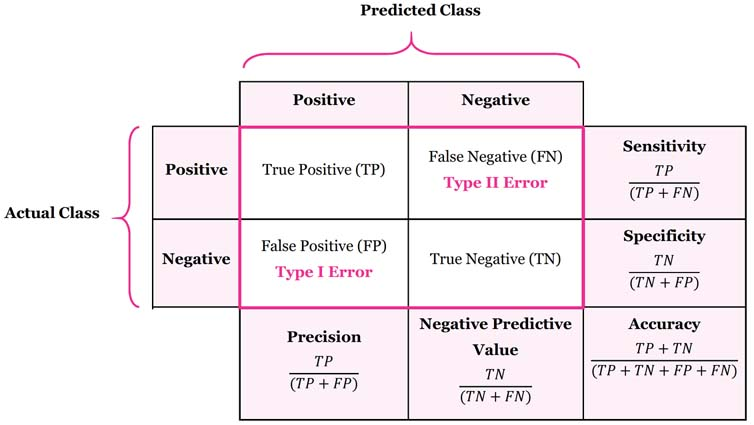

We can compute a confusion matrix in python using:

In [18]:
from sklearn.metrics import confusion_matrix

# Known labels
actual_class = [1, 0, 1, 1, 0, 0, 1, 1, 0, 1]
# Predicted labels
predicted_class = [1, 0, 1, 1, 0, 0, 1, 1, 1, 0]

# Compute confusion matrix
confusion_matrix(actual_class, predicted_class)

array([[3, 1],
       [1, 5]])

One new critera that we can use is the **Area Under Curve (AUC)**. This metric focuses on accounting for the area underneath the Receiver Operating Characteristics (ROC) curve. ROC is the plot of the true positive rate (sensitivity) vs. false positive rate (1-specificity).


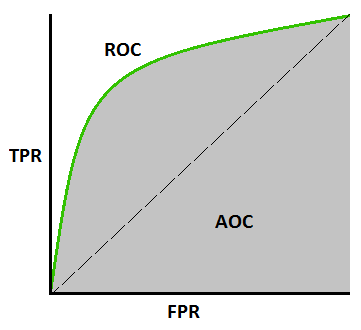

We can compute these values by: 

In [19]:
from sklearn.metrics import (plot_roc_curve,
                             roc_curve,
                           auc)

# New observations
new_data = {"x": [-2, -1, 0, 1, 2, 3]}
y_test = [0, 0, 0, 1, 1, 0]

# Estimate the expected output
y_predictions = simulated_model.predict(exog = new_data)

# Compute AUC 
fpr, tpr, threshold = roc_curve(y_test, y_predictions)
roc_auc = auc(fpr, tpr)
roc_auc

0.75

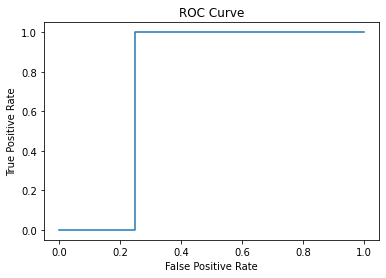

In [20]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Your Turn: Challenger o-ring data 



On January 28, 1986, the NASA space shuttle orbiter Challenger broke apart 73 seconds into its flight causing all crew members aboard to parish. The total failure of the challenger vehicle was the result of the failure of O-Ring seals at liftoff. This event became known as **Space Shuttle Challenger disaster** and was studied continuously.

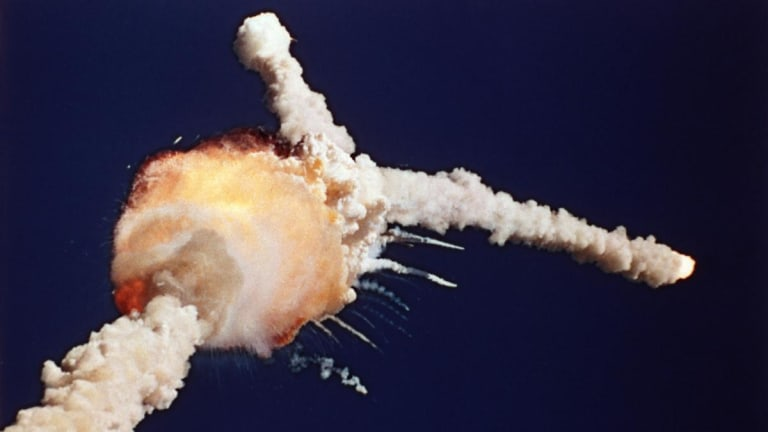

When the challenger space shuttle was launched, the temperature was colder than expected causing the O-Ring seal to fail. In the following weeks, NASA sought to then test the reliability of the O-Ring under different temperature conditions. The data collected is as-follows:

In [21]:
oring = [1,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0]
temperature = [53, 56, 57, 63, 66, 67, 67, 67, 68, 69, 70, 70, 70, 70, 72, 73, 75, 75, 76, 76, 78, 79, 80, 81]

**Note:** This data was available prior to the fateful launch of Challenger; however, there was a convincing argument made using the data to postpone or cancel the launch.

## a: Data Set Import

Please construct a pandas data frame called `challenger` using the two variables `oring` and `temperature` given above.

In [22]:
## code here

Obtain the frequency counts for the input data.

In [23]:
## code here

## b: Fit Simple Logistic Regression

With the `challenger` data frame, please fit a simple logistic regression such that would regress `oring` onto `temperature`.


Write down the model formula.

---

answer

---

With the model formula written, let's use `statsmodels` to fit the data.

In [24]:
## code here

Obtain the model summary information.

In [25]:
## code here

## c: Interpret the $\beta$ coefficient

What would be the interpretation for the $\beta_1$ 

## d: Perform a Hypothesis Test 

Using information from the challenger model summary, please perform a two-sided hypothesis test for the $\beta_1$ parameter.

$$
\begin{align*}
H_0: \beta_1 = 0\\
H_A: \beta_1 \neq 0\\
\end{align*}
$$

In [26]:
## code here

What was the conclusion from the hypothesis test? Did you reject the null hypothesis? 

## e: Obtain a prediction 

On the day of the challenger launch, the outside air was $\text{temperature} = 31$ degrees Fahrenheit. Using the model we have created, obtain a prediction. 

In [27]:
## code here

What would happen if NASA waited to launch challenger until the temperature was at 51 degrees Farhenheit? 

----

answer 

----

# Your Turn: Credit Default

Let's take a look at some credit card default data available on the UCI Irvine Repository. 

<https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients> 

There are 30000 observations and 25 variables:

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, - 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005
 (-1=pay duly, 1=payment delay for - one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)

## a: Import data set 

Please import the data set from: 

<https://raw.githubusercontent.com/inmas-training/fa21-statistical-methods-workshop/main/data/UCI_Credit_Card.csv> 

In [28]:
## code here

## b: Verify the data

Please verify the data has been imported correcting by looking at data attributes and checking the start and end of the data frame.

In [29]:
## code here 

## c: Explore the Data

Please create a pairwise plot on the data.

In [30]:
## code here

From the pairwise plot, consider a few different graphs using seaborn on variables that look interesting.

In [31]:
## code here

## d: Construct a model 

Next, let's construct a model on `default.payment.next.month ~ LIMIT_BAL + EDUCATION + SEX`. 

Recall, that when a variable has periods, we need to "quote" it using `Q("")`, e.g. `Q("default.payment.next.month")`'


In [32]:
## code here 

Are all the parameter coefficients in the model significant according to the hypothesis testing? 

---

answer 

---

Refit a model using only coefficients found to be signficant.

In [33]:
## Code Here

Please interpret each parameter of the new model. Recall, we hold other parameters constant when we are trying to interpret. 

--- 

answer

--- 

## e: Construct your own model!

Explore crafting your own model on the credit data. 

In [34]:
## 